## Importing necessary librararies

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
import warnings

In [4]:
#unzipping all the files
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        zf = ZipFile(path, 'r')
        zf.extractall('/dataset/')
        zf.close()

In [5]:
df =  pd.read_csv('/dataset/train.csv')
df = df.sample(frac=1, random_state=42)
train = df.sample(frac = 0.8).reset_index(drop = True)
test = df.drop(train.index).reset_index(drop = True)

In [6]:
df.shape,train.shape,test.shape

((159571, 8), (127657, 8), (31914, 8))

In [7]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,c03f72fd8f8bf54f,Carioca RFA \n\nThanks for your support on my ...,0,0,0,0,0,0
1,b5632fa10019dbdc,List of My Three Sons episodes \n\nI saw you r...,0,0,0,0,0,0
2,ed4448b7fef068f5,There are so many articles that wish to down p...,0,0,0,0,0,0
3,32cfb068392d728e,I see you have such a low self-esteem that you...,0,0,0,0,0,0
4,b0c9e9304f37c9d3,Renzoy16 ! Shut The Fuck Up,1,0,1,0,1,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127657 entries, 0 to 127656
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             127657 non-null  object
 1   comment_text   127657 non-null  object
 2   toxic          127657 non-null  int64 
 3   severe_toxic   127657 non-null  int64 
 4   obscene        127657 non-null  int64 
 5   threat         127657 non-null  int64 
 6   insult         127657 non-null  int64 
 7   identity_hate  127657 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 7.8+ MB


## EDA

<AxesSubplot:>

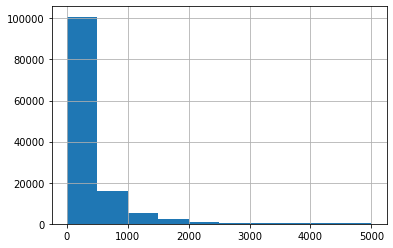

In [10]:
train.comment_text.apply(lambda x : len(x)).hist()

In [11]:
non_negaitve_comments = len(train[train.iloc[:,2:].apply(lambda x: sum(x), axis=1)==0])
negative_comments = len(train)-non_negaitve_comments
print("non_negaitve_comments",non_negaitve_comments)
print("negative_comments: ",negative_comments)
print(f"percentage of non negaitve comments :{non_negaitve_comments/len(train)*100}%")

non_negaitve_comments 114702
negative_comments:  12955
percentage of non negaitve comments :89.85171200952553%


In [12]:
multiple_labels = len(train[train.iloc[:,2:].apply(lambda x: sum(x), axis=1)>1])
print("multiple labeled comments: ",multiple_labels)

multiple labeled comments:  7894


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

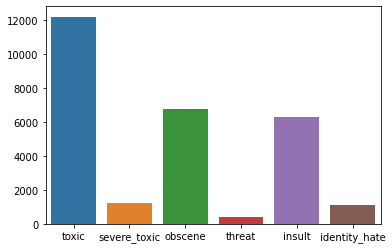

In [13]:
categories = []
values = []
for column in train.columns[2:]:
    categories.append(column)
    values.append(train[column].sum())

sns.barplot(categories,values)

In [14]:
def word_cloud(column):
    corpus = []
    category_df = train[train[column] ==1].reset_index(drop=True)
    for j in tqdm(range(0, len(category_df))):
        comment = re.sub('[^a-zA-Z]', ' ', category_df['comment_text'][j]) 
        comment = comment.lower() 
        comment = comment.split() 
        lemmatizer = WordNetLemmatizer() 
        comment = [lemmatizer.lemmatize(word) for word in comment]
        comment = ' '.join(comment)
        corpus.append(comment)
        
    text = ' '.join(corpus)
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(column)
    plt.axis("off")


  0%|          | 0/12217 [00:00<?, ?it/s]

  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 0/6752 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/6295 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

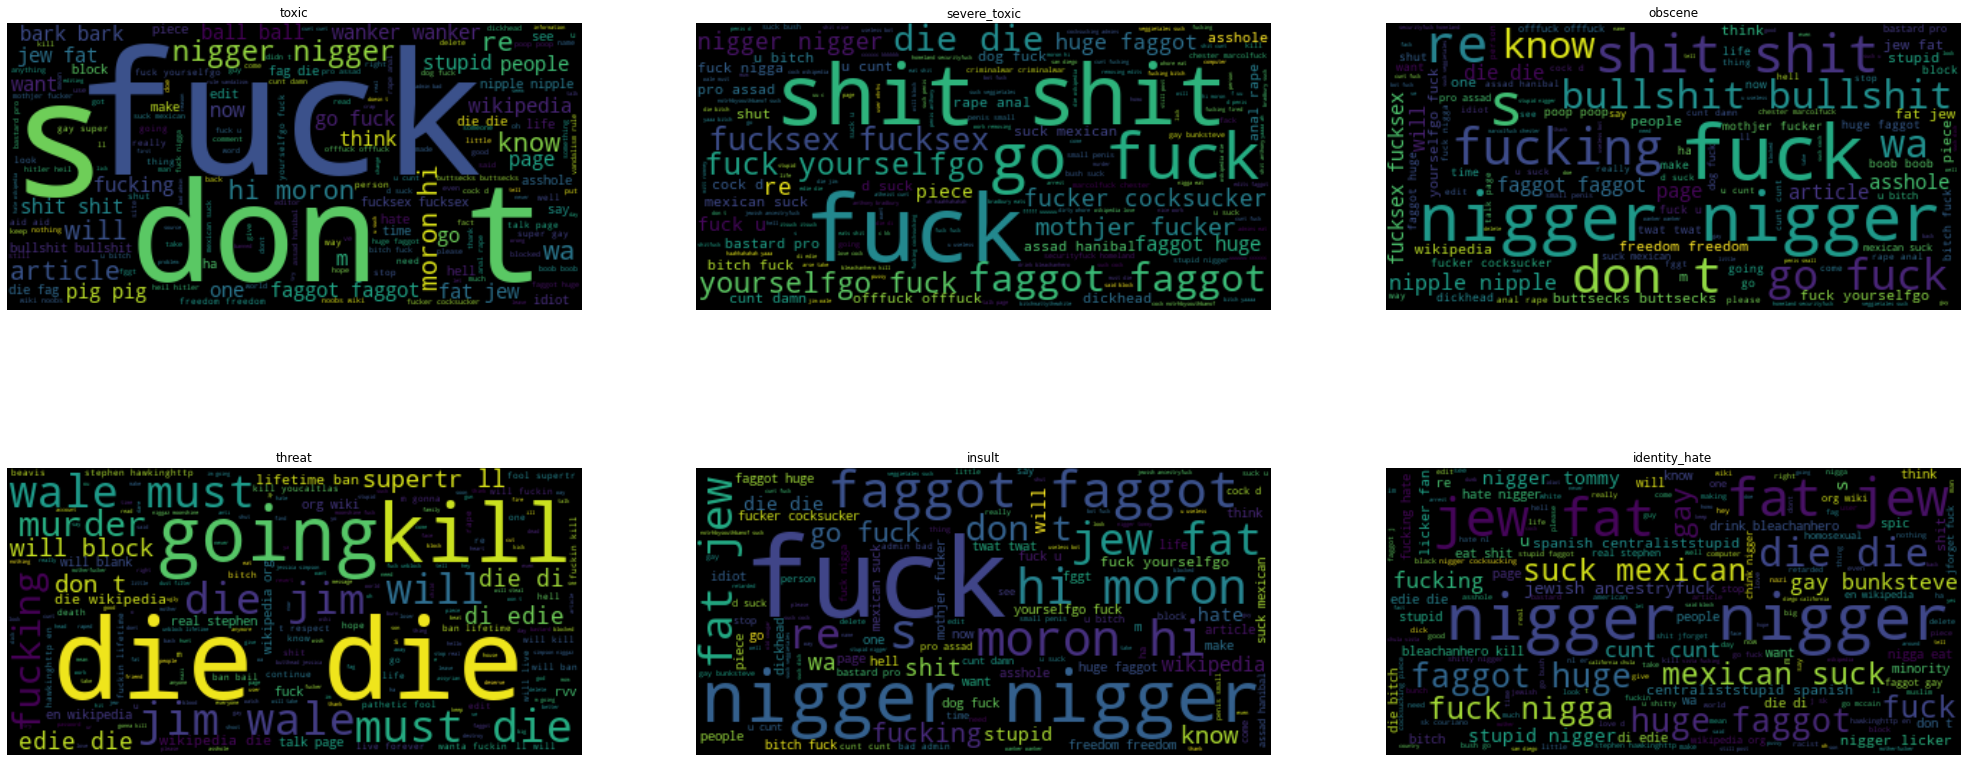

In [15]:
plt.figure(figsize=(35,15))
c = 1
for column in train.columns[2:]:
    plt.subplot(2,3,c)
    word_cloud(column)
    c=c+1

plt.show()

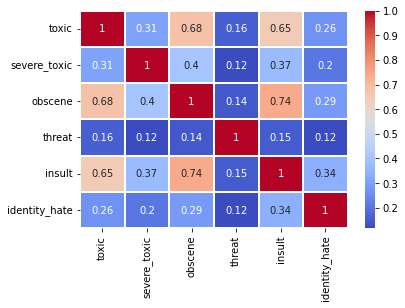

In [16]:
sns.heatmap(train.corr(), annot=True,cmap="coolwarm",linewidths=0.1)
plt.show()

In [17]:
train_corpus = []
for j in tqdm(range(0, len(train))):
    comment = re.sub('[^a-zA-Z]', ' ', train['comment_text'][j]) 
    comment = comment.lower() 
    comment = comment.split() 
    lemmatizer = WordNetLemmatizer() 
    comment = [lemmatizer.lemmatize(word) for word in comment]
    comment = ' '.join(comment)
    train_corpus.append(comment)

  0%|          | 0/127657 [00:00<?, ?it/s]

In [18]:
test_corpus = []
for j in tqdm(range(0, len(test))):
    comment = re.sub('[^a-zA-Z]', ' ', test['comment_text'][j]) 
    comment = comment.lower() 
    comment = comment.split() 
    lemmatizer = WordNetLemmatizer() 
    comment = [lemmatizer.lemmatize(word) for word in comment]
    comment = ' '.join(comment)
    test_corpus.append(comment)

  0%|          | 0/31914 [00:00<?, ?it/s]

In [19]:
vec = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X_train = vec.fit_transform(train_corpus)
X_test = vec.transform(test_corpus)

In [20]:
X_train.shape,X_test.shape

((127657, 316805), (31914, 316805))

In [22]:
predictions = pd.DataFrame()
predictions['id'] = test['id']

In [29]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for class_name in class_names:
    target_label = train[class_name]
    from sklearn.naive_bayes import MultinomialNB
    classifier = MultinomialNB()
    classifier.fit(X_train, target_label)
    pred = classifier.predict(X_test)
    predictions[class_name] = pred
    print(f"accuracy {class_name}: {accuracy_score(test[class_name], predictions[class_name])}")    

accuracy toxic: 0.9282759917277684
accuracy severe_toxic: 0.9903490631071004
accuracy obscene: 0.9579181550416745
accuracy threat: 0.9971172526164066
accuracy insult: 0.9564454471391866
accuracy identity_hate: 0.9904430657391741


In [137]:
predictions.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,c03f72fd8f8bf54f,0,0,0,0,0,0
1,b5632fa10019dbdc,0,0,0,0,0,0
2,ed4448b7fef068f5,0,0,0,0,0,0
3,32cfb068392d728e,0,0,0,0,0,0
4,b0c9e9304f37c9d3,1,0,1,0,1,0
5,f2c6f81c46124998,0,0,0,0,0,0
6,d6adb1691865be86,0,0,0,0,0,0
7,c5e1f1eec174362c,0,0,0,0,0,0
8,e8075ef4262a156e,1,0,0,0,0,0
9,d69ca809e8c9b6cb,0,0,0,0,0,0
